In [28]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time
# from scipy.spatial import cKDTree


In [29]:
df_data = pd.read_pickle(f"/srv/scratch/z5297792/Chapter2/Eddy_Detection_Data/df_data_{start_day}_cont.pkl")
df_data.Day.max()

np.int64(5308)

In [2]:
start_day = 1462
end_day = 2000

df_data = pd.read_pickle(f"/srv/scratch/z5297792/Chapter2/Eddy_Detection_Data/df_data_{start_day}_cont.pkl")
df_data = df_data.dropna() # If DOPIOE didnt work then we dont have vorticity, which is required for tracking
df_data.rename(columns={'Eddy': 'Eddy_idx'}, inplace=True)

df_data = df_data[(df_data['Day']>=start_day)&(df_data['Day']<=end_day)]

df_data


,Eddy_idx,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,xc,yc,w,Q11,Q12,Q22,Rc,psi0
0,0,1462,AE,160.569072,-28.075269,830.0,1515.0,830,1515,830.505283,1516.358103,0.000017,0.002904,-0.000396,0.005650,24.781075,-36.259933
1,1,1462,AE,155.725082,-27.535036,358.0,1408.0,358,1408,357.830407,1407.502025,0.000031,0.009018,-0.002230,0.006642,49.001445,-48.187084
2,2,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,928.354369,1356.372262,-0.000011,-0.001907,0.001393,-0.003376,73.000954,169.571400
3,3,1462,CE,156.973832,-28.452969,506.0,1354.0,506,1354,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145
4,4,1462,AE,159.170505,-29.807511,754.0,1285.0,754,1285,753.364302,1284.532290,0.000022,0.006509,-0.001848,0.004420,64.751400,-23.291117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25181,44,2000,AE,150.866227,-38.461252,308.0,115.0,308,115,307.367189,118.368235,0.000007,0.003134,0.000896,0.000529,42.752998,-1.613423
25182,45,2000,AE,149.289189,-38.184338,168.0,97.0,168,97,170.727622,97.152866,0.000014,0.001042,-0.000530,0.006131,8.767682,-0.332967
25183,46,2000,CE,148.676117,-38.308889,122.0,66.0,122,66,121.403871,66.469794,-0.000013,-0.003875,0.001791,-0.002656,5.297742,1.780577
25184,47,2000,AE,149.223039,-38.503549,174.0,62.0,174,62,174.178625,62.271658,0.000013,0.001906,-0.002030,0.004676,22.501137,-2.673219


In [3]:
start_ID = np.arange(len(df_data[df_data['Day']==df_data['Day'].min()]))
next_num = np.max(start_ID) + 1

# checkpoint_path = f"/srv/scratch/z5297792/Chapter2/Eddy_Detection_Data/df_eddies_{df_data.Day.min()}_{df_data.Day.max()}.pkl"

# df_eddies, df_R = tracking_fast(
#     df_data,
#     start_ID=start_ID,
#     next_num=next_num,
#     VORT_WEIGHT=15_000_000,
#     R_THRESH=50,
#     lookback_days=4,
#     checkpoint_every=200,          # save every 200 days processed
#     checkpoint_path=checkpoint_path
# )


In [4]:
def tracking(df_data, start_ID, next_num, VORT_WEIGHT=1e14, R_THRESH=60):

    tic = time.perf_counter()
    df_data = df_data.copy()
    min_day = df_data['Day'].min()
    df_data['Eddy'] = -1
    df_data.loc[df_data['Day'] == min_day, 'Eddy'] = start_ID
    df_data['Eddy'] = df_data['Eddy'].astype('Int64')

    unique_days = sorted(df_data['Day'].unique())
    day_dict = {
        d: df_data.index[(df_data['Day'] == d) & (~df_data['xc'].isna())]
        for d in unique_days
    }

    df_R_rows = []
    max_day = df_data['Day'].max()

    for day in range(min_day + 1, max_day + 1):
        if day not in day_dict or len(day_dict[day]) == 0:
            continue

        pres_day = df_data.loc[day_dict[day]].copy()
        unique_eddies = pres_day['Eddy_idx'].unique()
        assigned_IDs = set()  ### MODIFIED ### track assigned IDs per day

        for e_pres in unique_eddies:
            pres_eddy = pres_day[pres_day['Eddy_idx'] == e_pres].iloc[0]
            best_match = None
            best_R = np.inf

            for delta in range(1, 5): # Looks back 4 days max
                candidate_day = day - delta
                if candidate_day < min_day:
                    continue
                if candidate_day not in day_dict or len(day_dict[candidate_day]) == 0:
                    continue

                candidate_prev = df_data.loc[day_dict[candidate_day]]
                candidate_group = candidate_prev.groupby('Eddy_idx', as_index=False, sort=False).first()

                for _, prev_eddy in candidate_group.iterrows():
                    dx = pres_eddy['xc'] - prev_eddy['xc']
                    dy = pres_eddy['yc'] - prev_eddy['yc']
                    dw = pres_eddy['w'] - prev_eddy['w']
                    R = np.sqrt(dx ** 2 + dy ** 2 + VORT_WEIGHT * (dw ** 2))
                    D_diff = np.hypot(dx, dy)
                    W_diff = np.abs(dw)

                    df_R_rows.append({'D_diff': D_diff, 'W_diff': W_diff, 'R': R})

                    # Check match criteria
                    if (
                        R < R_THRESH
                        and pres_eddy['Cyc'] == prev_eddy['Cyc']
                        and prev_eddy['Eddy'] not in assigned_IDs  ### MODIFIED ###
                        and not pd.isna(prev_eddy['Eddy'])
                    ):
                        if R < best_R:
                            best_match = prev_eddy
                            best_R = R

            if best_match is not None:
                matched_id = best_match['Eddy']
                df_data.loc[(df_data['Day'] == day) & (df_data['Eddy_idx'] == e_pres), 'Eddy'] = matched_id
                assigned_IDs.add(matched_id)  ### MODIFIED ###
            else:
                df_data.loc[(df_data['Day'] == day) & (df_data['Eddy_idx'] == e_pres), 'Eddy'] = next_num
                assigned_IDs.add(next_num)  ### MODIFIED ###
                next_num += 1

        if day % 200 == 0:
            toc = time.perf_counter()
            print(f"Elapsed time: {toc - tic:.4f} seconds")
            print(day)

    df_R = pd.DataFrame(df_R_rows)
    df_data['next_num'] = next_num

    # Final check for duplicates
    assert not df_data.duplicated(subset=['Eddy', 'Day']).any(), "Duplicate (Eddy, Day) pairs found!"

    return df_data, df_R


In [5]:
df_eddies, df_R = tracking(df_data, start_ID, next_num)


Elapsed time: 60.3115 seconds
1600
Elapsed time: 212.9551 seconds
1800
Elapsed time: 307.4886 seconds
2000


In [6]:
df_R

,D_diff,W_diff,R
0,23.998518,0.000005,52.201416
1,508.975688,0.000019,542.748248
2,179.532018,0.000023,292.077480
3,386.255199,0.000045,593.437435
4,256.068499,0.000009,272.728408
...,...,...,...
3347992,767.618499,0.000003,768.055825
3347993,576.350195,0.000025,626.973106
3347994,334.185631,0.000026,425.112788
3347995,402.207384,0.000001,402.364614


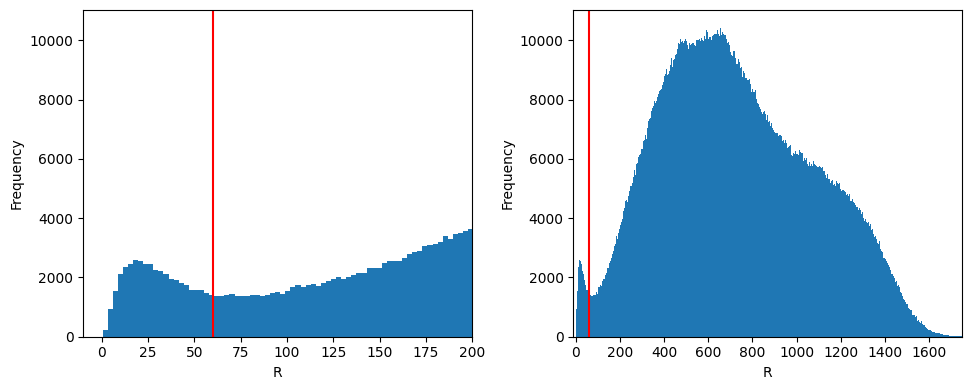

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist(df_R.R, bins=10000)
axs[0].axvline(x=60, color='r')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(-10, 200)

axs[1].hist(df_R.R, bins=10000)
axs[1].axvline(x=60, color='r')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(-10, 1750)

plt.tight_layout()


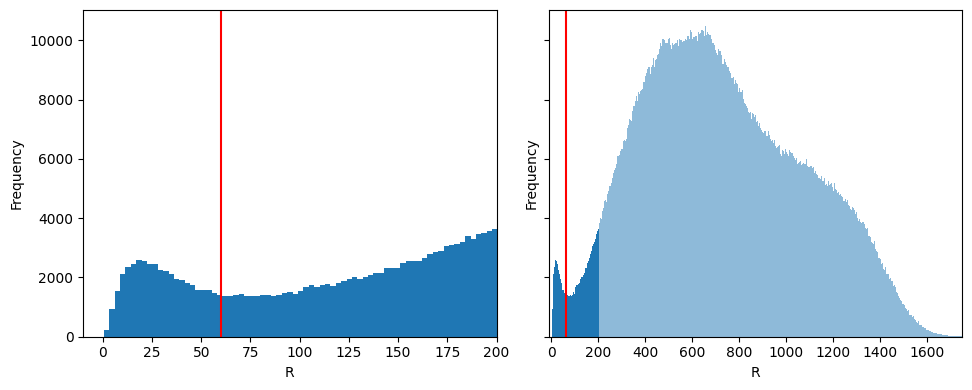

In [27]:
x = df_R['R'].to_numpy()
x = x[np.isfinite(x)]

def shaded_hist(ax, data, bins=10000, split=200, color='C0', alpha_in=1.0, alpha_out=0.5):
    n, edges, patches = ax.hist(data, bins=bins)
    centers = 0.5*(edges[:-1] + edges[1:])
    for c, p in zip(centers, patches):
        p.set_facecolor(color)
        p.set_alpha(alpha_in if (0 <= c <= split) else alpha_out)

fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

shaded_hist(axs[0], x, bins=10000, split=200)
axs[0].axvline(60, color='r')
axs[0].set_xlabel('R'); axs[0].set_ylabel('Frequency'); axs[0].set_xlim(-10, 200)

shaded_hist(axs[1], x, bins=10000, split=200)
axs[1].axvline(60, color='r')
axs[1].set_xlabel('R'); axs[1].set_ylabel('Frequency'); axs[1].set_xlim(-10, 1750)

plt.tight_layout()
plt.show()


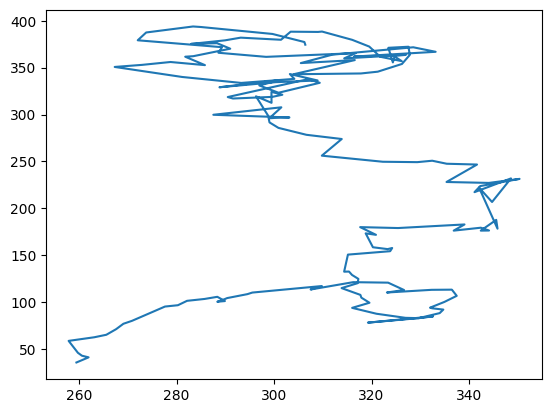

In [20]:
df = df_eddies[df_eddies.Eddy==df_eddies.Eddy.mode()[0]]

plt.plot(df.xc, df.yc)


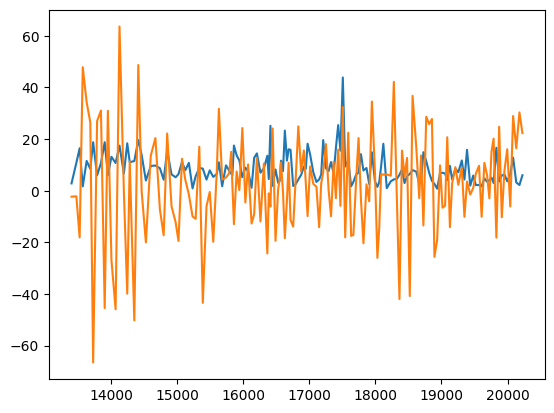

In [23]:
W = df.w.diff()
D = np.hypot(df.xc.diff(), df.yc.diff())
plt.plot(D)
VORT_WEIGHT=1e7
plt.plot(W*VORT_WEIGHT)

In [12]:
df_eddies.w.abs().mean()

np.float64(2.0583776888742898e-05)